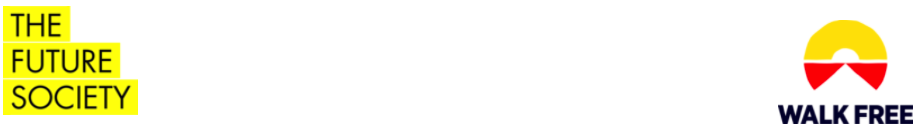

#*Project AIMS (AI against Modern Slavery)*

---




##💻 Note: You can run this notebook locally or on Google Colab following this [link](https://drive.google.com/file/d/1U8mRaizyBzrtmnmoht67hIcdtkXpCayx/view?usp=sharing).

# Performance Indicators

## Does the company define performance indicators that measure the effectiveness of their actions to combat modern slavery? 
Modern Slavery Key Performance Indicators (KPI) can help companies measure and track the impact of their decisions and policies and due diligence in addressing the modern slavery risks.
 
This task aims to check if a company measures the impact of the actions it takes while addressing the modern slavery incidents. And these key performance indicators can typically include:
- Any KPI measuring the impact of training provided to the workers against modern slavery and its effects.
- Any KPI related to measuring the number of incidents identified.
- Any KPI related to the usage of whistleblowing mechanisms detailed in the MSA Whistleblowing part above.
- Any KPIs related to the remediation steps taken and their effect like the number of contracts cancelled, number and types of corrective action plans etc.
- Any KPIs that measures the number of audits, on site or on plant visits, suppliers’ questionnaires, or the labour/worker monitoring mechanisms etc.
 
For further information on performance indicators, please refer to [WikiRate's UK Modern Slavery Act Research on MSA Performance Indicators metric](https://wikirate.org/Walk_Free_Foundation+MSA_Performance_Indicators) or [Home Office Guidance, pp. 36.](https://www.gov.uk/government/uploads/system/uploads/attachment_data/file/471996/Transparency_in_Supply_Chains_etc__A_practical_guide__final_.pdf)
 
### Labeled dataset
 
If the company discloses any of the above or related KPIs, the annotators label the statement with 'Yes' value and provide details in the Comments section. If the business indicates that it is planning to implement modern slavery KPIs, the annotator indicated 'In Development' and included details on the proposed KPIs in the Comments section. If no such KPIs exist or are described in the statement, the label  'No' was given.
To make the labelling task easier, binary encoding is conducted,   statements with performance metric values ‘No’, ‘In Development’ and ‘In Development and ‘No’, are encoded as 0; otherwise, statements that have ‘Yes’ in their performance metric value are encoded as 1.
 
 
 


## Setup

In [ ]:
#!pip install snorkel
%cd /content/drive/MyDrive/ProjectAIMS

/content/drive/.shortcut-targets-by-id/11tRyVLvElSSvedZDsiP76NndaI3wNyFb/Project AIMS


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import spacy
import en_core_web_sm
import sys
import pandas as pd
import re
import tqdm
import snorkel
import nltk 
from nltk import word_tokenize, pos_tag

from utils import sentencizer, evaluation_rb
#import evaluation_rb
#from sentencizer import custom_sentencizer
nlp = en_core_web_sm.load()
#nlp.add_pipe(custom_sentencizer, before="parser")
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### 🗄️ You can access the data used in this notebook [here](https://drive.google.com/file/d/1gr9PbPTaYLnhVKJ6eraJboPmvLZ_E14J/view?usp=sharing). We recommend you re-run this research with an updated version of this data which can be downloaded following these [instructions](https://github.com/the-future-society/Project-AIMS-AI-against-Modern-Slavery/tree/main/%F0%9F%97%84%EF%B8%8F%20Data%20and%20text%20extraction/WikiRate).


In [ ]:
metric ='Walk Free Foundation+MSA Performance Indicators'
metric_binary = metric+' binary'

labeled_dataset = pd.read_csv("./labeled-dataset.csv", dtype=object,  index_col=0)

print('Number of available statements for {} -> {:,}\n'.format(metric, labeled_dataset.shape[0]))

Number of available statements for Walk Free Foundation+MSA Performance Indicators -> 2,749



In [ ]:
# select relevant columns
columns = ['Answer ID', 'Answer Link', 'Metric', 'Company', 'Year', 'Value', 'Source', 'TEXT', metric]
data = labeled_dataset[columns]

# Remove unknown values from metric column
data = data.loc[(data[metric] != "Unknown") & (data[metric] != "unknown") & (data[metric] != " ") ,:]

# Remove empty values from metric column
data = data[data[metric].notna()]

# Remove rows with empty text cells
data = data[data['TEXT'].notna()]

#remove rows with duplicated text 
data = data.drop_duplicates(subset = 'TEXT')

print("Final number of data points in the labeled dataset is:")
print(data[metric].value_counts())

Final number of data points in the labeled dataset is:
No                904
Yes               272
In Development    112
Name: Walk Free Foundation+MSA Performance Indicators, dtype: int64


In [ ]:
# define a binary metric
no_values = ['No',
            'In Development',
            'In Development, No']

In [ ]:
data[metric_binary] = [1 if value not in no_values else 0 for value in data[metric]]

## Define keywords

A list of keywords is used to identify if the statements’ sentences contain information about the company's MSA KPI. In this case, as well, the keywords need some pre-processing. Basic steps are performed as a first stage of pre-processing, including removing empty text values, empty metric values, duplicate data rows, etc.
 
There are 1288 statements in total available for labelling after cleaning the data. After basic pre-processing, it is clear that most of the total statements, i.e.  904 statements have a metric value of ‘No’, which means they did not disclose anything about the MSA KPI. There are 112 statements that indicates that the company is still planning to implement modern slavery KPIs. And there are 272 statements that clearly indicate that the companies are implementing modern slavery KPIs. To make the labelling task easier, binary encoding is conducted,   statements with performance metric values ‘No’, ‘In Development’ and ‘In Development and ‘No’, are encoded as 0; otherwise, statements that have ‘Yes’ in their performance metric value are encoded as 1.
 
A few keywords are considered for the auto-labelling purpose, such as ‘measuring the impact of training’, ‘monitoring mechanisms’, etc. These keywords are also in the raw form and need some processing like lemmatisation and tense checking. After lemmatisation, the final set of keywords which is taken into consideration for labelling contains below keywords: ‘action take’, ‘assess risk’, ‘effectiveness’, ‘impact’, ‘KPIs, ‘measure’, ‘measure impact’, ‘measure impact training’, ‘monitor mechanism’, ‘number audits’, ‘review’, ‘site visit’, ‘supplier questionnaire’, ‘track’.
 

In [ ]:
few_keywords = ["measure impact", "track", "action taken", "measuring the impact of training", "number of audits", 
                "on site visits", "suppliers questionnaires", "monitoring mechanisms", "assess the risk", "review our", 
                "measure our", "review and", "KPIs", "effectiveness", "impact"]


We extract the lemmas from the keyword lists

In [ ]:
def get_keyword_lemmas(keywords_list):
    """
    Given a list of keyword combinations, extract lemmas from them.
    :param keywords_list: provided list of keywords describing a particular metric.
    """
    keywords_lemmas = list()
    for doc in nlp.pipe(keywords_list):
        keyword_lemma = [t.lemma_.lower() for t in doc if (not t.is_punct) and (not t.is_stop) and (not t.is_space) ]
        keyword_lemma = ' '.join(keyword_lemma)
        keywords_lemmas.append( keyword_lemma)

    keywords_lemmas = set(keywords_lemmas)

    return keywords_lemmas


In [ ]:
few_keywords_lemmas = get_keyword_lemmas(few_keywords)

In [ ]:
few_keywords_lemmas

{'action take',
 'assess risk',
 'effectiveness',
 'impact',
 'kpis',
 'measure',
 'measure impact',
 'measure impact training',
 'monitoring mechanism',
 'number audits',
 'review',
 'site visit',
 'supplier questionnaire',
 'track'}

Next, we'll define some functions to get the tense of a sentence and another one for, given a text, extracting the sentences with the lemma of any of our relevant keywords present.

In [ ]:
def tense(sentence):
    text = word_tokenize(sentence)
    tagged = pos_tag(text)

    tense = {}
    tense["future"] = len([word for word in tagged if word[1] == "MD"])
    tense["present"] = len([word for word in tagged if word[1] in ["VBP", "VBZ","VBG"]])
    tense["past"] = len([word for word in tagged if word[1] in ["VBD", "VBN"]]) 

    if max(tense, key=tense.get) == 0:
        return 'present'
    else:
        return max(tense, key=tense.get)

In [ ]:
def get_sentences_w_keywords(doc, few_keywords_lemmas, tokens_at_a_time=10, steps=3):
    """
    Extract sentences where keyword lemmas can be found.
    :param doc: tokenized text using a spacy parser model
    :param few_keywords_lemmas: a set of lemmatised keywords to use for searching sentences.
    :param tokens_at_a_time: Window size in tokens in which keywords are searched at ta time, the default is 10
    :param steps: how many tokens to move the window forward, the default is 3

    """
    
    elements_set = list()
    
    doc_len = len(doc)
    
    for kw in few_keywords_lemmas:
        dict_elements = dict()

        for idx in range(0, doc_len, steps):
            # print(idx)
            span = doc[idx:idx+tokens_at_a_time]
            span_lemmas = ' '.join([t.lemma_.lower() for t in span if (not t.is_punct) and (not t.is_stop) and (not t.is_space)])
            if kw in span_lemmas:

                dict_elements = dict()

                start_index = doc.text.index(span.sent.text)
                end_index = start_index + len(span.sent.text)-1
                dict_elements['element'] = kw
                dict_elements['sentence'] = span.sent.text.replace('\n', '') # remove new line tokens from sentences.
                dict_elements['span'] = ':'.join([str(start_index), str(end_index)])
                dict_elements['tense'] = tense_is = tense(span.sent.text)

                elements_set.append(dict_elements)

                
    return elements_set

def get_unique_sentences(dictionaries_list):
    unique_dicts = list({v['sentence']:v for v in dictionaries_list}.values())
    return unique_dicts
        

In [ ]:
%%time
extractions = [get_sentences_w_keywords(doc, few_keywords_lemmas) for doc in tqdm.tqdm(nlp.pipe(data['TEXT'], disable=["tagger", "ner", "textcat"], n_process=8, batch_size=10))]
extractions = [get_unique_sentences(dictionaries_list) for dictionaries_list in extractions]
data['extractions'] = extractions

1288it [05:01,  4.27it/s]


CPU times: user 4min 44s, sys: 3.3 s, total: 4min 47s
Wall time: 5min 1s


In [ ]:
from snorkel.labeling import labeling_function
from snorkel.labeling.model import LabelModel
from snorkel.labeling import LabelingFunction
from snorkel.labeling import PandasLFApplier
from snorkel.labeling import LFAnalysis
from snorkel.labeling.model import MajorityLabelVoter

# For clarity, we define constants to represent the class labels for yes, no, and abstaining.
ABSTAIN = -1
NO = 0
YES = 1

In [ ]:
@labeling_function()
def find_keyword_elements(x):
    """
    If no elements were found using the keywords then return NO, otherwise YES.
    """
    if x['extractions'] == []:
        return NO
    else:
        return YES


In [ ]:
lfs = [find_keyword_elements]

applier = PandasLFApplier(lfs=lfs)
L_test = applier.apply(df=data)

coverage_approval_metric = (L_test == YES).mean(axis=0)
print(coverage_approval_metric)
print(LFAnalysis(L=L_test, lfs=lfs).lf_summary())


/opt/conda/lib/python3.8/site-packages/tqdm/std.py:702: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 1288/1288 [00:00<00:00, 71709.88it/s]

[0.84860248]
                       j Polarity  Coverage  Overlaps  Conflicts
find_keyword_elements  0   [0, 1]       1.0       0.0        0.0


In [ ]:
label_model = LabelModel()
majority_model = MajorityLabelVoter()
final_labels = majority_model.predict(L=L_test)

# Results 



In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_true, y_pred=y_hat))

              precision    recall  f1-score   support

           0       0.90      0.17      0.29      1016
           1       0.23      0.93      0.37       272

    accuracy                           0.33      1288
   macro avg       0.57      0.55      0.33      1288
weighted avg       0.76      0.33      0.31      1288



In [ ]:
data[metric+' predicted'] = final_labels

In [ ]:
data.to_csv('./msa-performance-predicted.csv')

The overall accuracy of this exercise is 33%, the overall precision is  76%, and the overall recall is 33%. Based on those results, we can say that these indicators are not good metric predictors.


## Testing with a sample


In [ ]:
data_sample = data.sample(10).reset_index(drop=True)

In [ ]:

extractions = [get_sentences_w_keywords(doc, few_keywords_lemmas) for doc in tqdm.tqdm(nlp.pipe(data_sample['TEXT']))]
extractions = [get_unique_sentences(dictionaries_list) for dictionaries_list in extractions]
data_sample['extractions'] = extractions

10it [00:02,  4.86it/s]


In [ ]:
data_sample['extractions']

0    [{'element': 'review', 'sentence': 'As part of...
1    [{'element': 'review', 'sentence': 'In additio...
2    [{'element': 'review', 'sentence': 'The result...
3    [{'element': 'review', 'sentence': 'The ten pr...
4    [{'element': 'review', 'sentence': 'The Group ...
5    [{'element': 'review', 'sentence': 'for allcre...
6    [{'element': 'review', 'sentence': 'When conce...
7                                                   []
8    [{'element': 'review', 'sentence': 'This is a ...
9    [{'element': 'measure', 'sentence': 'The Bank ...
Name: extractions, dtype: object

In [ ]:
def example_generator(extracted_sentences):
    for sent in extracted_sentences:
        yield sent

pos_gen = example_generator(data_sample['extractions'])

In [ ]:
next(pos_gen)

[{'element': 'review',
  'sentence': 'As part of our commitment to combating modern slavery, and as described initially in our FY2016 UK Modern Slavery Act Statement (“FY2016 Statement”) we have been conducting a review of key policies, procedures and contractual terms for suppliers.',
  'span': '5910:6155',
  'tense': 'present'},
 {'element': 'review',
  'sentence': 'Utilizing third-party data and our own research, we have marked allegations of forced labor and child labor as indicators that would immediately place a client on our ESRM watchlist, which means that going forward, any transaction with that client must be reviewed by the ESRM team directly, who in turn would engage the client to conduct further due diligence on the allegations.',
  'span': '16879:17258',
  'tense': 'present'},
 {'element': 'action take',
  'sentence': 'Retaliation is a serious issue and includes any adverse action taken because an employee has engaged in such activity.',
  'span': '11947:12064',
  'tense'

In [ ]:
next(pos_gen)

[{'element': 'review',
  'sentence': 'In addition, Morgan Stanley’s existing Global Franchise Risk and Global Environmental and Social Risk Policies outline requirements for heightened sensitivity and review where business activities or operations may be at high risk of exposure to human rights abuses.',
  'span': '3568:3833',
  'tense': 'future'},
 {'element': 'review',
  'sentence': 'vendor due diligence program assesses risk associated with third party suppliers. The assessment includes a review of the supplier’s litigation history, regulatory profile and negative media coverage using publicly available material and news sources.',
  'span': '4103:4353',
  'tense': 'present'},
 {'element': 'review',
  'sentence': 'The assessment includes a review of the supplier’s litigation history, regulatory profile and negative media coverage using publicly available material and news sources.',
  'span': '4185:4353',
  'tense': 'present'},
 {'element': 'review',
  'sentence': 'In 2016, Morgan S

In [ ]:
next(pos_gen)

[{'element': 'review',
  'sentence': 'The results of theseassessments will be shared with the suppliers and based on the results, an improvement plan can be established,subject to review at the six-month point.',
  'span': '5918:6092',
  'tense': 'past'},
 {'element': 'measure',
  'sentence': 'The aim of the charter is to encourage the suppliers of the signatory banks to implement vigilance measures aspart of their overall ESR approach.',
  'span': '3239:3384',
  'tense': 'present'},
 {'element': 'measure',
  'sentence': 'The French Act on the Duty of Vigilance requires Natixis to prepare, publish and implement a vigilance action plancontaining measures capable of identifying and preventing risks of violating human rights and basic freedoms, theenvironment, and occupational health and safety, associated with the activities conducted by BPCE as well as itssubsidiaries, sub-contractors and suppliers.',
  'span': '4237:4623',
  'tense': 'present'},
 {'element': 'measure',
  'sentence': 'T